In [2]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import expanduser

In [3]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
RT_LOWER = 1650
RT_UPPER = 2200

#### prepare the MaxQuant results

In [4]:
mq_results_df = pd.read_csv('{}/evidence-P3856.txt'.format(expanduser('~')), sep='\\t', engine='python')

In [5]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# only those identifications for this run
mq_results_df = mq_results_df[mq_results_df['Raw file'] == run_name]
# only MS/MS
mq_results_df = mq_results_df[mq_results_df['Type'] == 'TIMS-MULTI-MSMS']
# remove identifications with large mass error
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 20.0]
# only those in the RT region of interest
mq_results_df = mq_results_df[(mq_results_df['Retention time']*60.0 > RT_LOWER) & (mq_results_df['Retention time']*60.0 < RT_UPPER)]

In [12]:
mq_results_df['Type'].unique()

array(['TIMS-MULTI-MSMS'], dtype=object)

In [6]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [21]:
mq_sequences_l = []
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    mq_sequences_l.append({'unique_peptide_key':group_name, 'mass_error_ppm':group_df['Mass error [ppm]'].min()})
unique_identifications_mq_df = pd.DataFrame(mq_sequences_l)

In [22]:
len(unique_identifications_mq_df)

7293

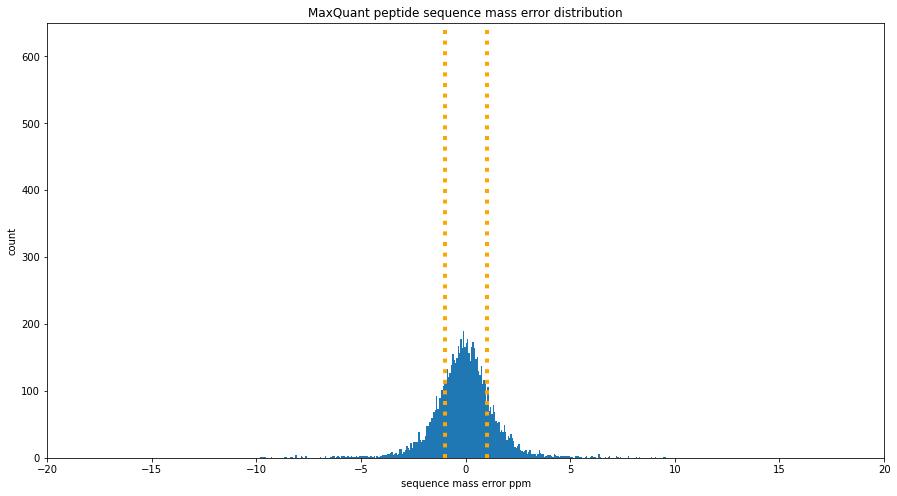

In [23]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('MaxQuant peptide sequence mass error distribution')

bins = 300
hist, bins, _ = plt.hist(mq_results_df['Mass error [ppm]'], bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,650))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

In [24]:
unique_identifications_mq_df.sample(n=20)

,unique_peptide_key,mass_error_ppm
7230,"(YSESLLCSNLESATYSNR, Unmodified, 2)",2.06000
619,"(AYHNSPAYLAYINAK, Unmodified, 2)",1.74260
3924,"(LPSGVFSLEFQDFVNK, Unmodified, 2)",1.86110
5920,"(TFCGTPDYIAPEIIAYQPYGK, Unmodified, 2)",-1.11180
5298,"(RPEAAQLLEDVQAALKPFSVK, Unmodified, 3)",2.03620
3133,"(ISFCLDIHNMSVK, Unmodified, 2)",-2.13390
532,"(ATCIGNNSAAAVSMLK, Unmodified, 2)",-1.66570
6837,"(VVIGMDVAASEFFR, Unmodified, 2)",-0.73692
6173,"(TPYTDVNIVTIR, Unmodified, 2)",-1.59640
1967,"(FVINYDYPNSSEDYIHR, Unmodified, 2)",1.65170


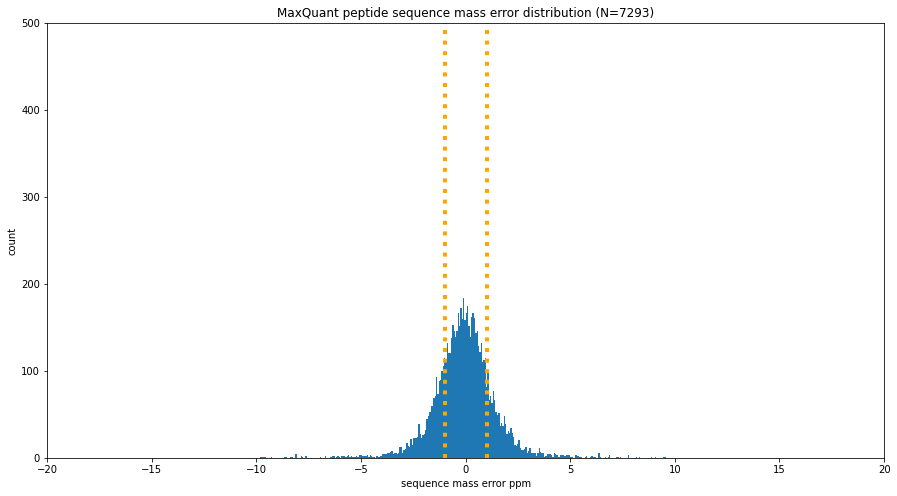

In [26]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('MaxQuant peptide sequence mass error distribution (N={})'.format(len(unique_identifications_mq_df)))

bins = 300
hist, bins, _ = plt.hist(unique_identifications_mq_df.mass_error_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,500))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### prepare the MSFragger results

In [22]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSstats-without-MBR.csv'.format(EXPERIMENT_DIR), sep=',')


In [23]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [24]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
212564,sp|P26368|U2AF2_HUMAN,LFIGGLPNYLNDDQVK,2,NaN,NaN,L,YHE114,4,P3856_YHE114_4_Slot1-1_1_5118,83068.330
500722,sp|Q6P2Q9|PRP8_HUMAN,GPGNPVPGPLAPLPDYMSEEK,2,NaN,NaN,L,YHE211,2,P3856_YHE211_2_Slot1-1_1_5105,195592.890
188000,sp|P21281|VATB2_HUMAN,GPVVLAEDFLDIMGQPINPQC[57.0215]R,3,NaN,NaN,L,YHE211,10,P3856_YHE211_10_Slot1-1_1_5113,28382.742
642703,sp|Q9P258|RCC2_HUMAN,NHTLALTETGSVFAFGENK,2,NaN,NaN,L,YHE114,3,P3856_YHE114_3_Slot1-1_1_5117,68730.630
373177,sp|P63010|AP2B1_HUMAN,LAPPLVTLLSGEPEVQYVALR,3,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,31515.666


In [25]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [26]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])